LOG + t-Distribution

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf

First we write a function to import the data of our stocks - Here we are using Log returns 


In [102]:
def get_data(stocks,start,end):
    stockdata = yf.download(stocks, start=start, end=end)
    stockdata = stockdata['Close'] 
    stockdata = stockdata.dropna(axis=1, how='all')   
    returns = np.log(stockdata / stockdata.shift(1))
    meanreturns=returns.mean()
    covmatrix=returns.cov()
    return meanreturns,covmatrix

We give the list of stocks, start date and end date 

In [103]:
stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList] 
endDate=dt.datetime.now()
startDate=endDate - dt.timedelta(days=366)
meanreturns, covariancematrix = get_data(stocks,startDate,endDate)

/var/folders/1x/rl_n22g17zz8ckt64mkz9vsr0000gn/T/ipykernel_6086/2455547726.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stockdata = yf.download(stocks, start=start, end=end)
[*********************100%***********************]  6 of 6 completed


In [104]:
print(meanreturns) #-> We can print the mean returns 

Ticker
BHP.AX   -0.000295
CBA.AX    0.001309
NAB.AX    0.000427
STO.AX    0.000056
TLS.AX    0.001117
WBC.AX    0.000894
dtype: float64


We create a random porfilio of the above stocks

In [105]:
weights=np.random.random(len(meanreturns))
weights/=np.sum(weights)

In [106]:
print(weights)# -> We will get random n weights whose sum will be 1

[0.21805805 0.16928688 0.26641446 0.1310229  0.13966401 0.0755537 ]


Input the number of simulations and how many days and portfolio amount

In [107]:
mc_sims=500 #number of simulations 
T=365 #number of days 
initialportfolio=1000 #Initial portfolio amount

Initialising the mean returns array and value at every day array

In [108]:
meanM= np.full(shape=(T,len(weights)),fill_value=meanreturns)
meanM=meanM.T

portfolio_sims=np.full(shape=(T,mc_sims),fill_value=0.0)

The basic montecarlo simultation Loop

In [109]:
for m in range(0,mc_sims):
    #MC Loops 
    df = 5  # Degrees of freedom (lower df = fatter tails)
    Z = np.random.standard_t(df, size=(T, len(weights)))
    L = np.linalg.cholesky(covariancematrix)
    dailyreturns = meanM + np.inner(L, Z)
    portfolio_sims[:, m] = np.exp(np.cumsum(np.inner(weights, dailyreturns.T))) * initialportfolio

Plotting all the simulations

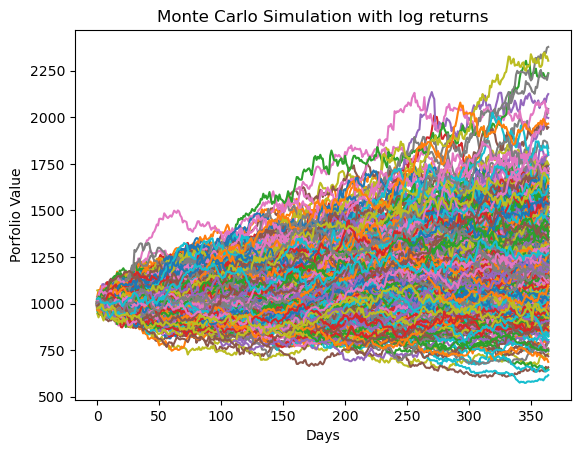

In [110]:
plt.plot(portfolio_sims)
plt.ylabel('Porfolio Value')
plt.xlabel('Days')
plt.title('Monte Carlo Simulation with log returns')
plt.show()

Histogram of all the final values of the various simulations

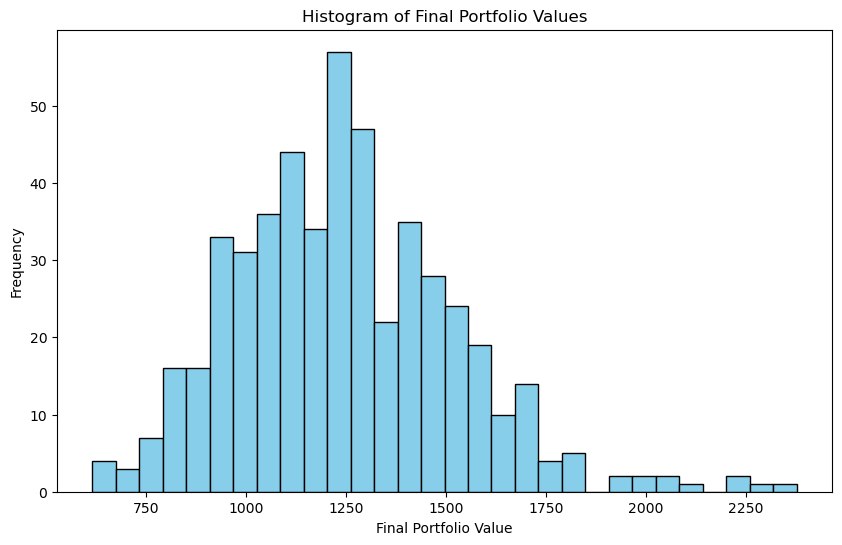

In [111]:
final_portfolios = portfolio_sims[-1, :]  # Get the last day values from all simulations

plt.figure(figsize=(10,6))
plt.hist(final_portfolios, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Final Portfolio Values')
plt.xlabel('Final Portfolio Value')
plt.ylabel('Frequency')
plt.show()

Pie Chart of the stocks allocation

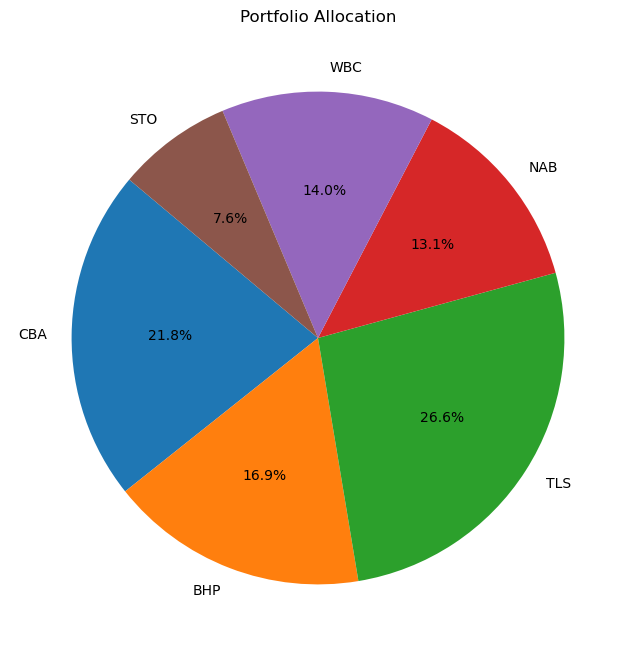

In [112]:
plt.figure(figsize=(8,8))
plt.pie(weights, labels=stockList, autopct='%1.1f%%', startangle=140)
plt.title('Portfolio Allocation')
plt.show()

If we add Sector wise mapping, we can get sector wise split of porfolio

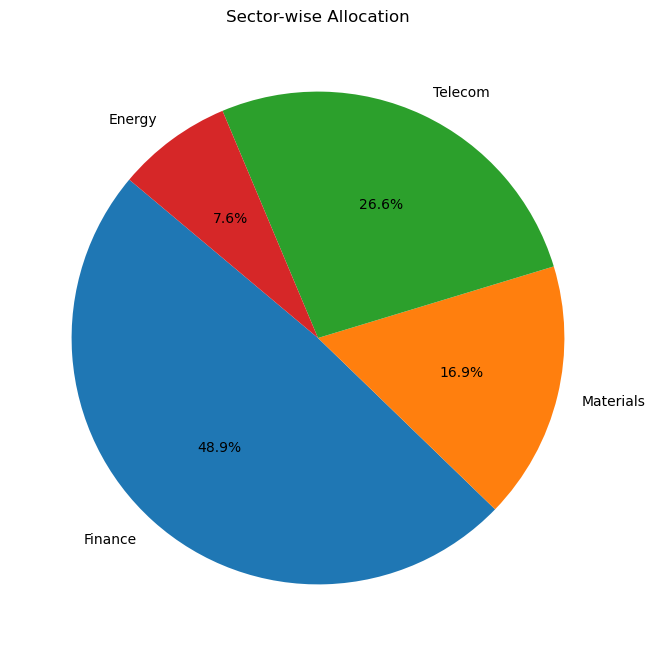

In [113]:
sectors = {
    'CBA': 'Finance',
    'BHP': 'Materials',
    'TLS': 'Telecom',
    'NAB': 'Finance',
    'WBC': 'Finance',
    'STO': 'Energy'
}

sector_weights = {}
for i, stock in enumerate(stockList):
    sector = sectors[stock]
    sector_weights[sector] = sector_weights.get(sector, 0) + weights[i]

plt.figure(figsize=(8,8))
plt.pie(sector_weights.values(), labels=sector_weights.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Sector-wise Allocation')
plt.show()


Mean returns in percentage 

In [114]:
mean_return_sim = np.mean(final_portfolios / initialportfolio - 1)*100
print(f"Mean Return from Simulations(%): {mean_return_sim:.4f}")

Mean Return from Simulations(%): 24.7331


Standard Deviation of the returns 

In [115]:
std_dev_sim = np.std(final_portfolios / initialportfolio - 1)
print(f"Standard Deviation of Returns: {std_dev_sim:.4f}")

Standard Deviation of Returns: 0.2782


Value at Risk (VaR) at 90%

In [116]:
VaR_90 = np.percentile(final_portfolios, 10)  # 10th percentile portfolio value
VaR_90_loss = initialportfolio - VaR_90
print(f"90% VaR (Potential Loss at 90% confidence): {VaR_90_loss:.2f}")

90% VaR (Potential Loss at 90% confidence): 84.32


Conditional VaR (CVaR / Expected Shortfall)

In [117]:
CVaR_90 = np.mean([initialportfolio - x for x in final_portfolios if x <= VaR_90])
print(f"90% CVaR (Expected Loss in worst 10% cases): {CVaR_90:.2f}")

90% CVaR (Expected Loss in worst 10% cases): 182.62


Sharpe Ratio

In [118]:
sharpe_ratio = mean_return_sim / std_dev_sim
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Sharpe Ratio: 88.9125


Sortino Ratio

In [119]:
downside_returns = np.minimum(0, final_portfolios / initialportfolio - 1)
sortino_ratio = mean_return_sim / (np.std(downside_returns[downside_returns != 0]))
print(f"Sortino Ratio: {sortino_ratio:.4f}")

Sortino Ratio: 274.8362


Max Drawdown

In [120]:
max_drawdowns = []
for m in range(mc_sims):
    cumulative = portfolio_sims[:, m]
    peak = np.maximum.accumulate(cumulative)
    drawdown = (peak - cumulative) / peak
    max_drawdowns.append(np.max(drawdown))

avg_max_drawdown = np.mean(max_drawdowns)
print(f"Average Max Drawdown across simulations: {avg_max_drawdown:.4f}")


Average Max Drawdown across simulations: 0.1810
